In [1]:
pip install pandas torch transformers scikit-learn datasets seaborn matplotlib accelerate openpyxl

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import numpy as np

C:\Users\Wede\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# --- MEMUAT DAN MEMBERSIHKAN DATA ---
print("--- MEMUAT DAN MEMBERSIHKAN DATA ---")
input_filename = '../Data/hasil_pelabelan_transjakarta.csv'
try:
    df = pd.read_csv(input_filename)
    df.dropna(subset=['Teks_Stemmed'], inplace=True)
    df = df[df['Teks_Stemmed'].str.strip() != '']
    print(f"File '{input_filename}' berhasil dibaca. Jumlah data setelah dibersihkan: {len(df)} baris.")
except FileNotFoundError:
    print(f"Error: File '{input_filename}' tidak ditemukan.")
    exit()

--- MEMUAT DAN MEMBERSIHKAN DATA ---
File '../Data/hasil_pelabelan_transjakarta.csv' berhasil dibaca. Jumlah data setelah dibersihkan: 150 baris.


In [4]:
# --- PERSIAPAN DAN PEMBAGIAN DATA ---
print("\n--- PERSIAPAN DAN PEMBAGIAN DATA ---")
# Konversi label sentimen menjadi angka untuk model
labels = sorted(df['Sentimen'].unique())
label_map = {label: i for i, label in enumerate(labels)}
df['label'] = df['Sentimen'].map(label_map)

# Bagi data menjadi set latih (80%) dan set uji (20%)
X = df['Teks_Stemmed']
y = df['Sentimen']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Data dibagi menjadi: {len(X_train)} data latih dan {len(X_test)} data uji.")


--- PERSIAPAN DAN PEMBAGIAN DATA ---
Data dibagi menjadi: 120 data latih dan 30 data uji.


# TAHAP MODEL UNTUK TF-IDF DAN LOGISTIC REGRESSION

In [5]:
print("\n\n--- MEMULAI TAHAP MODEL UNTUK TF-IDF DAN LOGISTIC REGRESSION ---")

# --- FEATURE ENGINEERING DENGAN TF-IDF ---
print("\n--- FEATURE ENGINEERING (TF-IDF) ---")
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
print("Fitur TF-IDF berhasil dibuat.")



--- MEMULAI TAHAP MODEL UNTUK TF-IDF DAN LOGISTIC REGRESSION ---

--- FEATURE ENGINEERING (TF-IDF) ---
Fitur TF-IDF berhasil dibuat.


In [6]:
# --- PELATIHAN DAN EVALUASI MODEL LOGISTIC REGRESSION ---
print("\n--- PELATIHAN DAN EVALUASI MODEL LOGISTIC REGRESSION ---")
logreg_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
logreg_model.fit(X_train_tfidf, y_train)
y_pred_logreg = logreg_model.predict(X_test_tfidf)
print("Model Logistic Regression berhasil dilatih dan dievaluasi.")


--- PELATIHAN DAN EVALUASI MODEL LOGISTIC REGRESSION ---
Model Logistic Regression berhasil dilatih dan dievaluasi.


# TAHAP UNTUK MODEL INDOBERT

In [7]:
print("\n\n--- MEMULAI TAHAP UNTUK MODEL INDOBERT ---")

# --- FINE-TUNING DAN EVALUASI INDOBERT ---
# Siapkan data untuk Hugging Face
train_df_bert = pd.DataFrame({'Teks_Stemmed': X_train, 'label': y_train.map(label_map)})
test_df_bert = pd.DataFrame({'Teks_Stemmed': X_test, 'label': y_test.map(label_map)})
train_dataset = Dataset.from_pandas(train_df_bert)
test_dataset = Dataset.from_pandas(test_df_bert)

# Tokenisasi
print("\nMemuat tokenizer IndoBERT...")
model_name = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples['Teks_Stemmed'], padding="max_length", truncation=True, max_length=256)

print("Melakukan tokenisasi data untuk BERT...")
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Memuat model
print("\nMemuat model IndoBERT untuk klasifikasi...")
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(labels))

# Argumen Pelatihan
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="steps",
    eval_steps=10,
    save_strategy="steps",
    save_steps=10,
    load_best_model_at_end=True
)

# Inisialisasi Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

print("\nMemulai proses fine-tuning IndoBERT...")
trainer.train()
print("Pelatihan IndoBERT selesai.")

# Prediksi dengan model BERT
print("Melakukan prediksi dengan model IndoBERT...")
predictions_bert = trainer.predict(test_dataset)
y_pred_indices_bert = np.argmax(predictions_bert.predictions, axis=1)
y_pred_bert = [labels[i] for i in y_pred_indices_bert]



--- MEMULAI TAHAP UNTUK MODEL INDOBERT ---

Memuat tokenizer IndoBERT...
Melakukan tokenisasi data untuk BERT...


Map: 100%|██████████| 30/30 [00:00<00:00, 1823.93 examples/s]


Memuat model IndoBERT untuk klasifikasi...



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Memulai proses fine-tuning IndoBERT...


C:\Users\Wede\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss
10,0.926800,0.885932
20,0.920900,0.902864
30,0.661900,0.580140
40,0.378800,0.570381


C:\Users\Wede\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Wede\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Wede\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Pelatihan IndoBERT selesai.
Melakukan prediksi dengan model IndoBERT...


C:\Users\Wede\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


# TAHAP PERBANDINGAN PERFORMA MODEL



--- TAHAP PERBANDINGAN PERFORMA MODEL ---

--- 1. Hasil Evaluasi Model TF-IDF dan Logistic Regression ---
Akurasi Model: 73.33%

Laporan Klasifikasi:
              precision    recall  f1-score   support

     negatif       0.75      0.60      0.67        10
      netral       0.00      0.00      0.00         3
     positif       0.73      0.94      0.82        17

    accuracy                           0.73        30
   macro avg       0.49      0.51      0.50        30
weighted avg       0.66      0.73      0.69        30


--- 2. Hasil Evaluasi Model IndoBERT ---
Akurasi Model: 76.67%

Laporan Klasifikasi:
              precision    recall  f1-score   support

     negatif       0.70      0.70      0.70        10
      netral       0.00      0.00      0.00         3
     positif       0.80      0.94      0.86        17

    accuracy                           0.77        30
   macro avg       0.50      0.55      0.52        30
weighted avg       0.69      0.77      0.72        30



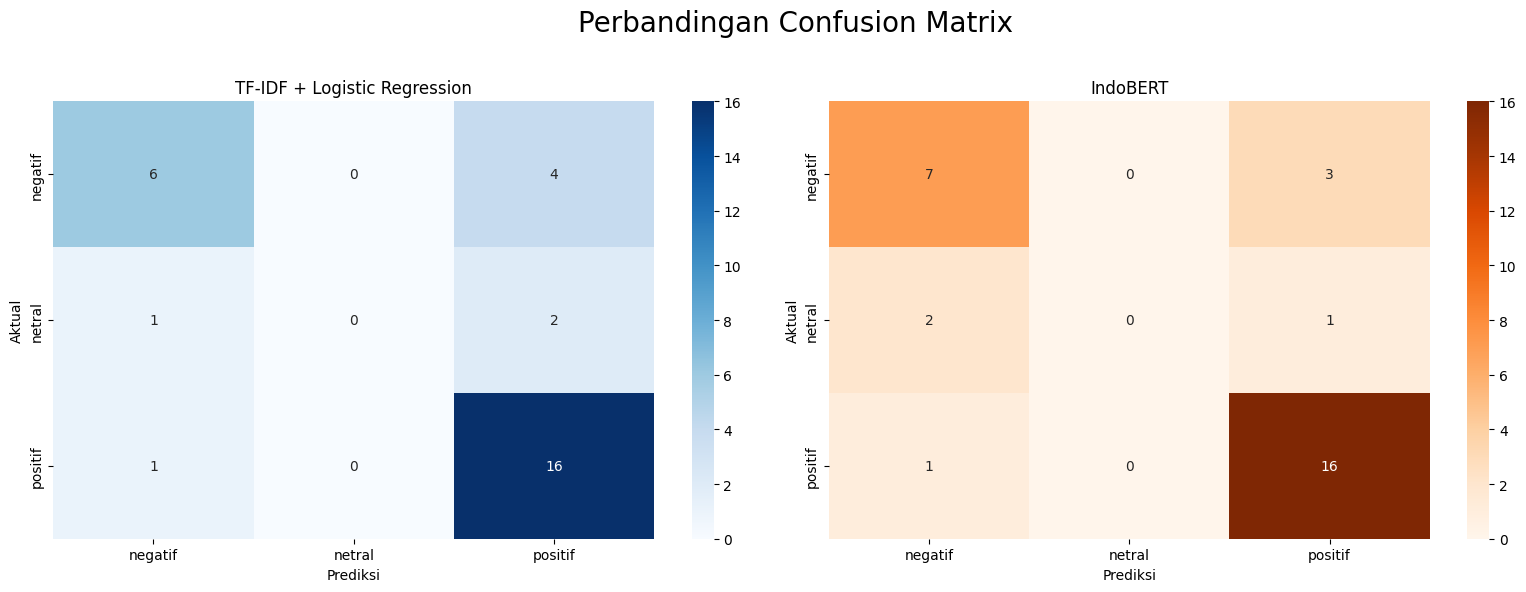


✅ Seluruh proses proyek selesai.


In [9]:
print("\n\n--- TAHAP PERBANDINGAN PERFORMA MODEL ---")

# --- Hasil Model TF-IDF dan Logistic Regression ---
print("\n--- 1. Hasil Evaluasi Model TF-IDF dan Logistic Regression ---")
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Akurasi Model: {accuracy_logreg:.2%}")
print("\nLaporan Klasifikasi:")
print(classification_report(y_test, y_pred_logreg, zero_division=0))

# --- Hasil Model IndoBERT ---
print("\n--- 2. Hasil Evaluasi Model IndoBERT ---")
accuracy_bert = accuracy_score(y_test, y_pred_bert)
print(f"Akurasi Model: {accuracy_bert:.2%}")
print("\nLaporan Klasifikasi:")
print(classification_report(y_test, y_pred_bert, zero_division=0))


# --- Visualisasi Confusion Matrix Berdampingan ---
print("\nMembuat visualisasi perbandingan Confusion Matrix...")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Perbandingan Confusion Matrix', fontsize=20)

# Confusion Matrix untuk Logistic Regression
cm_logreg = confusion_matrix(y_test, y_pred_logreg, labels=labels)
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title('TF-IDF + Logistic Regression')
axes[0].set_xlabel('Prediksi')
axes[0].set_ylabel('Aktual')

# Confusion Matrix untuk IndoBERT
cm_bert = confusion_matrix(y_test, y_pred_bert, labels=labels)
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Oranges', xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title('IndoBERT')
axes[1].set_xlabel('Prediksi')
axes[1].set_ylabel('Aktual')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("\n✅ Seluruh proses proyek selesai.")